In [1]:
# Cosine Learning Rate Decay (model_B+c)

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

# Load data
train_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\train'
val_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\val'

# Set image size (batch=64, epochs=10)
img_width, img_height = 224, 224
batch_size = 64
total_epochs = 10

# Set data generator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

# Load train & validation data to generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Import ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Configure model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Modify the block
for layer in model.layers:
    if 'conv1' in layer.name:  # If it is 1st conv layer
        layer.strides = (2, 2)  # Change stride to 2x2
    elif 'conv2_block1_0_conv' in layer.name:  # If it is 2nd conv layer
        layer.strides = (1, 1)  # Change stride to 1x1

# Set cosine learning rate decay (rate=0.001)
lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=total_epochs*train_generator.samples//batch_size)

# Apply cosine learning rate decay to Adam optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=total_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate model
val_loss, top1_val_accuracy, top5_val_accuracy = model.evaluate(val_generator)

# Print accuracy
print("Top-1 Validation Accuracy:", top1_val_accuracy)
print("Top-5 Validation Accuracy:", top5_val_accuracy)

# Learning log output
print(history.history)


Found 7316 images belonging to 102 classes.
Found 1828 images belonging to 102 classes.


Epoch 1/10


114/114 [==============================] - 266s 2s/step - loss: 2.2052 - accuracy: 0.5077 - top_k_categorical_accuracy: 0.6999 - val_loss: 28.1404 - val_accuracy: 0.0848 - val_top_k_categorical_accuracy: 0.1975
Epoch 2/10
114/114 [==============================] - 259s 2s/step - loss: 0.9769 - accuracy: 0.7376 - top_k_categorical_accuracy: 0.9142 - val_loss: 5.7844 - val_accuracy: 0.0536 - val_top_k_categorical_accuracy: 0.0848
Epoch 3/10
114/114 [==============================] - 258s 2s/step - loss: 0.5737 - accuracy: 0.8354 - top_k_categorical_accuracy: 0.9659 - val_loss: 6.7641 - val_accuracy: 0.0536 - val_top_k_categorical_accuracy: 0.0893
Epoch 4/10
114/114 [==============================] - 258s 2s/step - loss: 0.3615 - accuracy: 0.8919 - top_k_categorical_accuracy: 0.9861 - val_loss: 6.3673 - val_accuracy: 0.0910 - val_top_k_categorical_accuracy: 0.1936
Epoch 5/10
114/114 [==

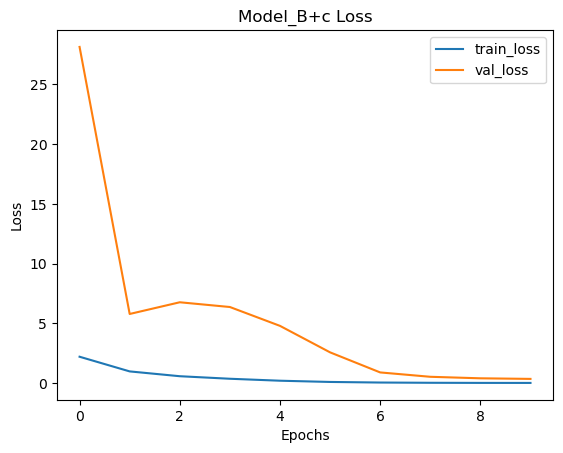

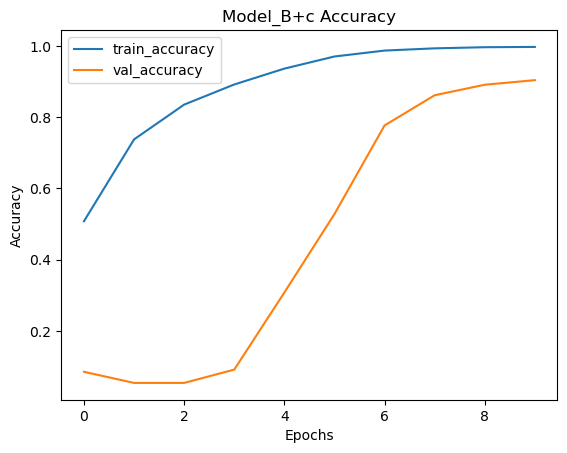

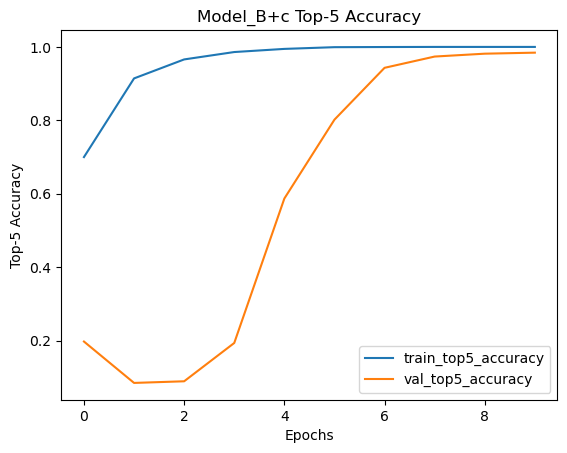

In [2]:
# Visualization Model_B+c learning log

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model_B+c Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model_B+c Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top5_accuracy')
plt.title('Model_B+c Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

In [3]:
# Label Smoothing (model_B+l)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

train_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\train'
val_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\val'

img_width, img_height = 224, 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    if 'conv1' in layer.name:  
        layer.strides = (2, 2)  
    elif 'conv2_block1_0_conv' in layer.name: 
        layer.strides = (1, 1)  


# Apply label smoothing to Loss functions (label smoothing=0.1)
loss = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy', 'top_k_categorical_accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

val_loss, top1_val_accuracy, top5_val_accuracy = model.evaluate(val_generator)

print("Top-1 Validation Accuracy:", top1_val_accuracy)
print("Top-5 Validation Accuracy:", top5_val_accuracy)

print(history.history)

Found 7316 images belonging to 102 classes.
Found 1828 images belonging to 102 classes.
Epoch 1/10
114/114 [==============================] - 265s 2s/step - loss: 2.4322 - accuracy: 0.5601 - top_k_categorical_accuracy: 0.7518 - val_loss: 4.8601 - val_accuracy: 0.0246 - val_top_k_categorical_accuracy: 0.0592
Epoch 2/10
114/114 [==============================] - 258s 2s/step - loss: 1.5783 - accuracy: 0.7741 - top_k_categorical_accuracy: 0.9359 - val_loss: 6.9966 - val_accuracy: 0.0536 - val_top_k_categorical_accuracy: 0.0804
Epoch 3/10
114/114 [==============================] - 258s 2s/step - loss: 1.3079 - accuracy: 0.8531 - top_k_categorical_accuracy: 0.9726 - val_loss: 6.0990 - val_accuracy: 0.0541 - val_top_k_categorical_accuracy: 0.0787
Epoch 4/10
114/114 [==============================] - 258s 2s/step - loss: 1.1571 - accuracy: 0.9066 - top_k_categorical_accuracy: 0.9880 - val_loss: 4.4923 - val_accuracy: 0.1150 - val_top_k_categorical_accuracy: 0.2383
Epoch 5/10
114/114 [========

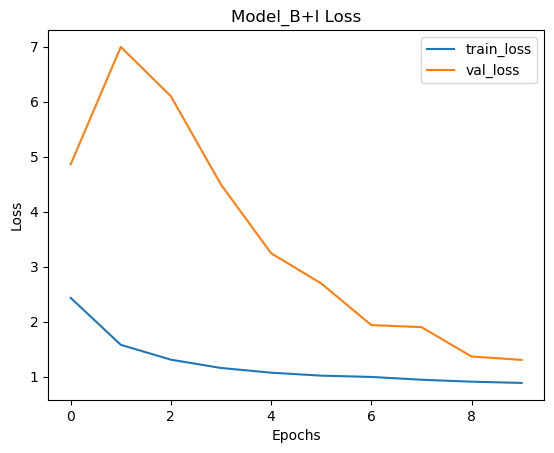

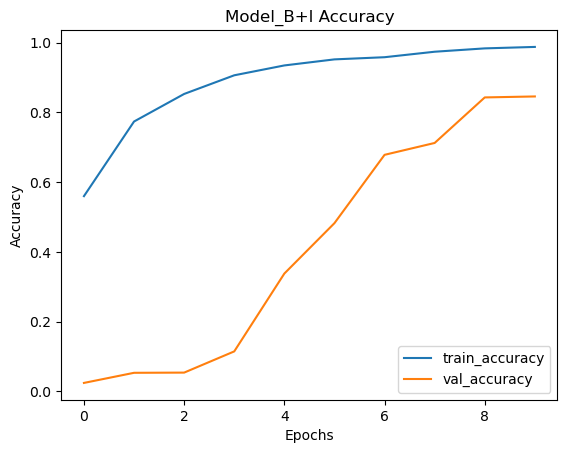

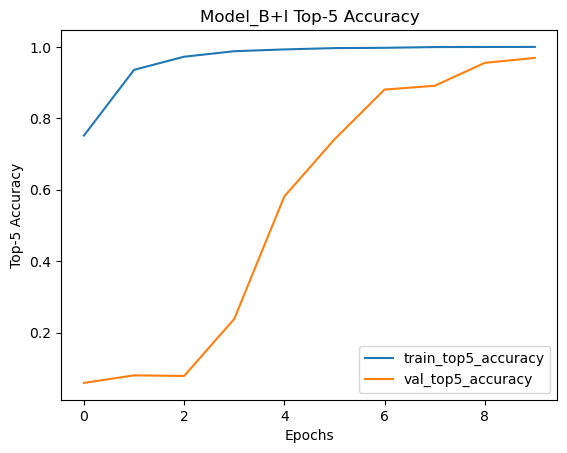

In [4]:
# Visualization Model_B+l learning log

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model_B+l Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model_B+l Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top5_accuracy')
plt.title('Model_B+l Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

In [5]:
# Mixup Train (Model_B+m)

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

train_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\train'
val_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\val'

img_width, img_height = 224, 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Mixup data generation function
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lambda_val = np.random.beta(alpha, alpha)
    else:
        lambda_val = 1

    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)

    mixed_x = lambda_val * x + (1 - lambda_val) * x[index]
    mixed_y = lambda_val * y + (1 - lambda_val) * y[index]

    return mixed_x, mixed_y

# Mixup data generator
def mixup_generator(generator, alpha=0.2):
    while True:
        x_batch, y_batch = next(generator)
        x_batch, y_batch = mixup_data(x_batch, y_batch, alpha=alpha)
        yield x_batch, y_batch

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    if 'conv1' in layer.name:
        layer.strides = (2, 2)  
    elif 'conv2_block1_0_conv' in layer.name:  
        layer.strides = (1, 1)  

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

# Use mixup data generator
train_mixup_generator = mixup_generator(train_generator)

history = model.fit(
    train_mixup_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

val_loss, top1_val_accuracy, top5_val_accuracy = model.evaluate(val_generator)

print("Top-1 Validation Accuracy:", top1_val_accuracy)
print("Top-5 Validation Accuracy:", top5_val_accuracy)

print(history.history)

Found 7316 images belonging to 102 classes.
Found 1828 images belonging to 102 classes.
Epoch 1/10
114/114 [==============================] - 267s 2s/step - loss: 2.6974 - accuracy: 0.4668 - top_k_categorical_accuracy: 0.6527 - val_loss: 6.8156 - val_accuracy: 0.0223 - val_top_k_categorical_accuracy: 0.1183
Epoch 2/10
114/114 [==============================] - 259s 2s/step - loss: 1.5706 - accuracy: 0.6866 - top_k_categorical_accuracy: 0.8776 - val_loss: 5.1035 - val_accuracy: 0.0067 - val_top_k_categorical_accuracy: 0.0854
Epoch 3/10
114/114 [==============================] - 259s 2s/step - loss: 1.3515 - accuracy: 0.7739 - top_k_categorical_accuracy: 0.9283 - val_loss: 5.0014 - val_accuracy: 0.0229 - val_top_k_categorical_accuracy: 0.0753
Epoch 4/10
114/114 [==============================] - 260s 2s/step - loss: 1.1906 - accuracy: 0.8200 - top_k_categorical_accuracy: 0.9522 - val_loss: 5.9351 - val_accuracy: 0.1295 - val_top_k_categorical_accuracy: 0.2584
Epoch 5/10
114/114 [========

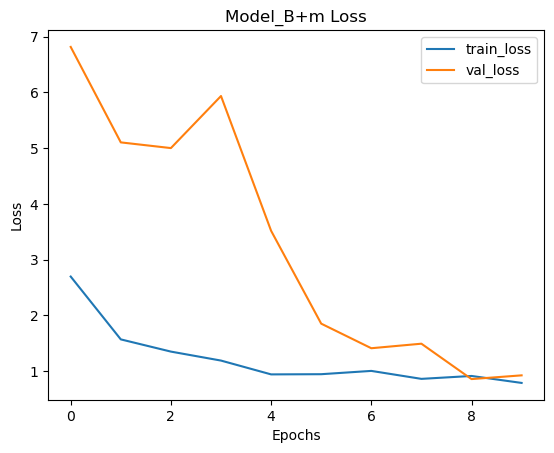

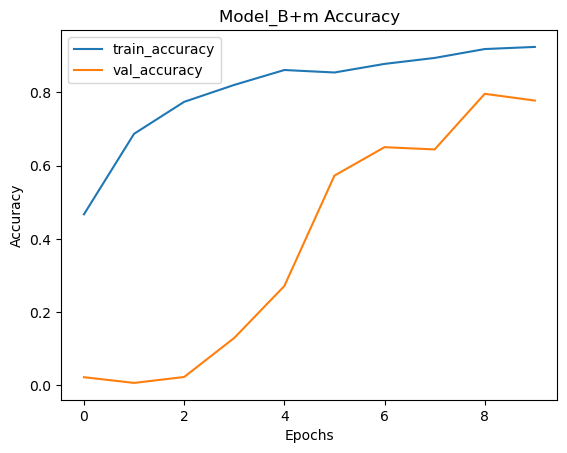

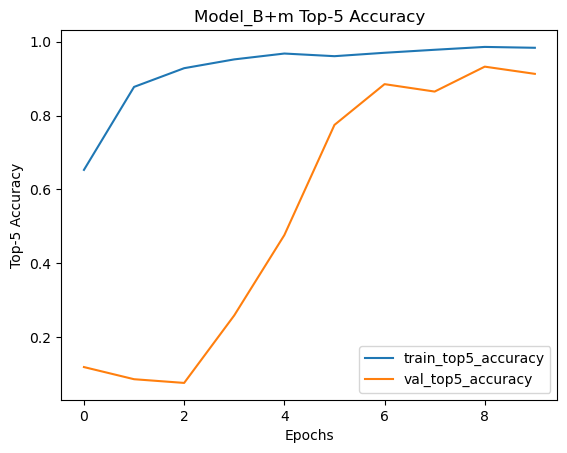

In [6]:
# Visualization Model_B+m learning log

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model_B+m Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model_B+m Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top5_accuracy')
plt.title('Model_B+m Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

In [7]:
# Cosine Decay + Label Smoothing (Model_B+c+l)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import CategoricalCrossentropy

train_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\train'
val_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\val'

img_width, img_height = 224, 224
batch_size = 64
total_epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    if 'conv1' in layer.name:  
        layer.strides = (2, 2)  
    elif 'conv2_block1_0_conv' in layer.name:  
        layer.strides = (1, 1)  

# Cosine learning rate decay
lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=total_epochs*train_generator.samples//batch_size)

# Apply to Adam optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Label smoothing value
label_smoothing = 0.1

# Label smoothing to the Categorical Crossentropy loss function
loss_function = CategoricalCrossentropy(label_smoothing=label_smoothing)

# Compile model (Apply label Smoothing)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', 'top_k_categorical_accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=total_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

val_loss, top1_val_accuracy, top5_val_accuracy = model.evaluate(val_generator)

print("Top-1 Validation Accuracy:", top1_val_accuracy)
print("Top-5 Validation Accuracy:", top5_val_accuracy)

print(history.history)

Found 7316 images belonging to 102 classes.
Found 1828 images belonging to 102 classes.
Epoch 1/10
114/114 [==============================] - 265s 2s/step - loss: 2.4192 - accuracy: 0.5661 - top_k_categorical_accuracy: 0.7536 - val_loss: 4.8369 - val_accuracy: 0.0117 - val_top_k_categorical_accuracy: 0.0346
Epoch 2/10
114/114 [==============================] - 258s 2s/step - loss: 1.5294 - accuracy: 0.7900 - top_k_categorical_accuracy: 0.9400 - val_loss: 5.1588 - val_accuracy: 0.0117 - val_top_k_categorical_accuracy: 0.0871
Epoch 3/10
114/114 [==============================] - 258s 2s/step - loss: 1.2363 - accuracy: 0.8846 - top_k_categorical_accuracy: 0.9796 - val_loss: 6.4301 - val_accuracy: 0.0547 - val_top_k_categorical_accuracy: 0.1038
Epoch 4/10
114/114 [==============================] - 259s 2s/step - loss: 1.0809 - accuracy: 0.9291 - top_k_categorical_accuracy: 0.9937 - val_loss: 5.2626 - val_accuracy: 0.1161 - val_top_k_categorical_accuracy: 0.2422
Epoch 5/10
114/114 [========

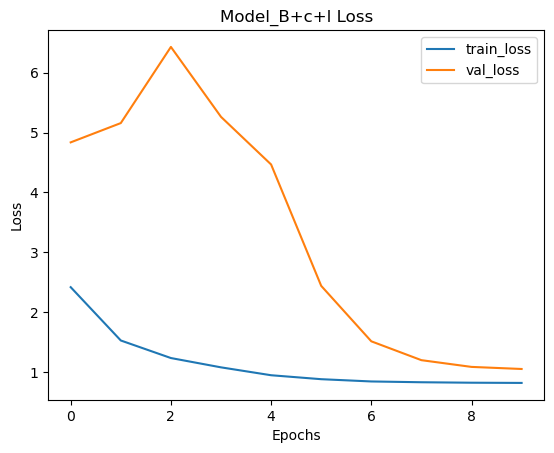

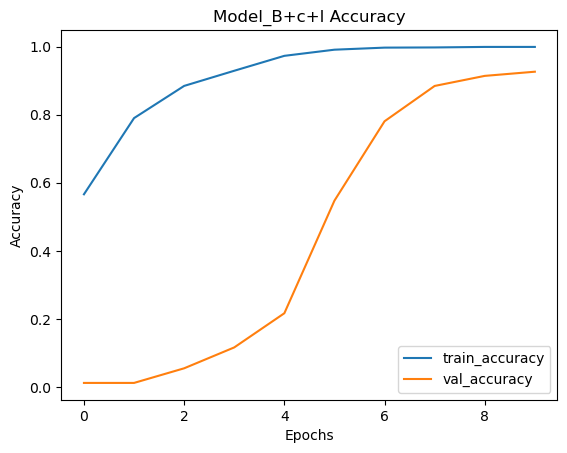

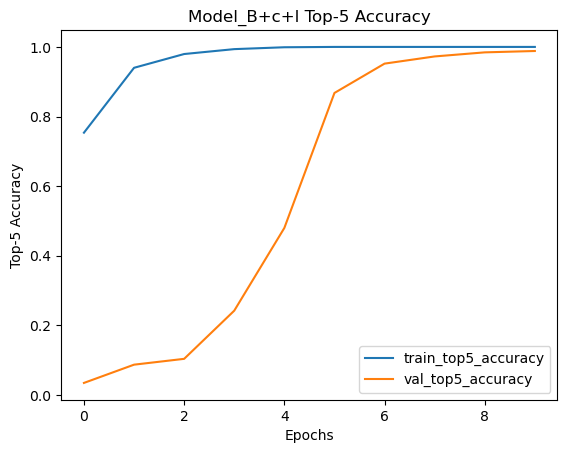

In [8]:
# Visualization Model_B+c+l learning log

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model_B+c+l Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model_B+c+l Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top5_accuracy')
plt.title('Model_B+c+l Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

In [9]:
# Cosine Decay + Mixup Train (Model_B+c+m)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

train_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\train'
val_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\val'

img_width, img_height = 224, 224
batch_size = 64
total_epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    if 'conv1' in layer.name: 
        layer.strides = (2, 2)  
    elif 'conv2_block1_0_conv' in layer.name:  
        layer.strides = (1, 1)  

lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=total_epochs*train_generator.samples//batch_size)

optimizer = Adam(learning_rate=lr_schedule)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lambda_ = np.random.beta(alpha, alpha)
    else:
        lambda_ = 1
    
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    
    mixed_x = lambda_ * x + (1 - lambda_) * x[index]
    mixed_y = lambda_ * y + (1 - lambda_) * y[index]
    
    return mixed_x, mixed_y

def mixup_generator(generator, alpha=0.2):
    while True:
        data = next(generator)
        images, labels = data[0], data[1]
        images, labels = mixup_data(images, labels, alpha)
        yield images, labels

train_mixup_generator = mixup_generator(train_generator)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

history = model.fit(
    train_mixup_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=total_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

val_loss, top1_val_accuracy, top5_val_accuracy = model.evaluate(val_generator)

print("Top-1 Validation Accuracy:", top1_val_accuracy)
print("Top-5 Validation Accuracy:", top5_val_accuracy)

print(history.history)

Found 7316 images belonging to 102 classes.
Found 1828 images belonging to 102 classes.
Epoch 1/10
114/114 [==============================] - 267s 2s/step - loss: 2.7828 - accuracy: 0.4460 - top_k_categorical_accuracy: 0.6283 - val_loss: 40.1048 - val_accuracy: 0.0463 - val_top_k_categorical_accuracy: 0.2494
Epoch 2/10
114/114 [==============================] - 259s 2s/step - loss: 1.6330 - accuracy: 0.6678 - top_k_categorical_accuracy: 0.8610 - val_loss: 6.3898 - val_accuracy: 0.0095 - val_top_k_categorical_accuracy: 0.0792
Epoch 3/10
114/114 [==============================] - 259s 2s/step - loss: 1.3066 - accuracy: 0.7664 - top_k_categorical_accuracy: 0.9208 - val_loss: 5.9491 - val_accuracy: 0.0536 - val_top_k_categorical_accuracy: 0.1685
Epoch 4/10
114/114 [==============================] - 259s 2s/step - loss: 1.1022 - accuracy: 0.8377 - top_k_categorical_accuracy: 0.9528 - val_loss: 4.7770 - val_accuracy: 0.1172 - val_top_k_categorical_accuracy: 0.2260
Epoch 5/10
114/114 [=======

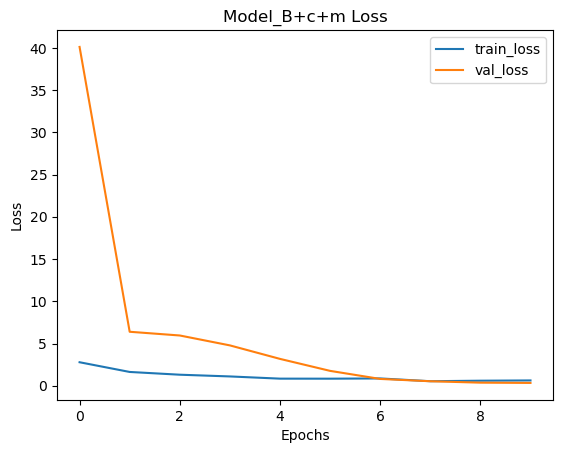

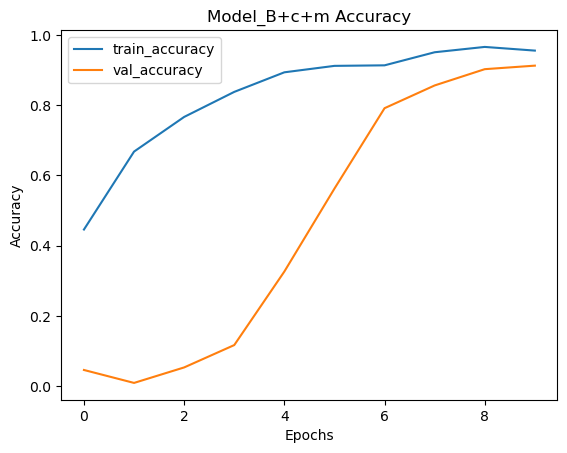

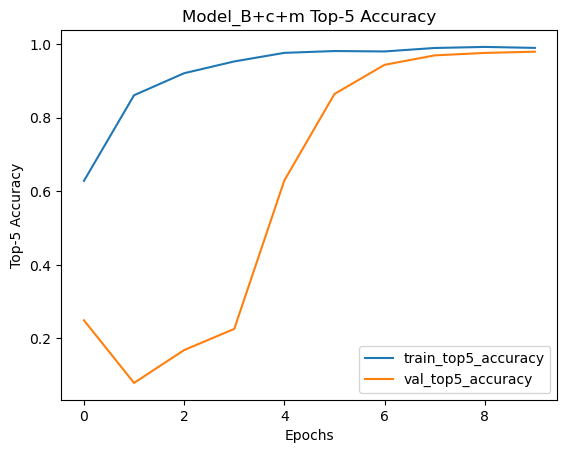

In [10]:
# Visualization Model_B+c+m learning log

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model_B+c+m Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model_B+c+m Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top5_accuracy')
plt.title('Model_B+c+m Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

In [11]:
# Label Smoothing + Mixup Train (Model_B+l+m)

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

train_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\train'
val_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\val'

img_width, img_height = 224, 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lambda_ = np.random.beta(alpha, alpha)
    else:
        lambda_ = 1
    
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    
    mixed_x = lambda_ * x + (1 - lambda_) * x[index]
    mixed_y = lambda_ * y + (1 - lambda_) * y[index]
    
    return mixed_x, mixed_y

def mixup_generator(generator, alpha=0.2):
    while True:
        data = next(generator)
        images, labels = data[0], data[1]
        images, labels = mixup_data(images, labels, alpha)
        yield images, labels

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    if 'conv1' in layer.name:  
        layer.strides = (2, 2)  
    elif 'conv2_block1_0_conv' in layer.name:  
        layer.strides = (1, 1)  

loss = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy', 'top_k_categorical_accuracy'])

mixup_train_generator = mixup_generator(train_generator)

history = model.fit(
    mixup_train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

val_loss, top1_val_accuracy, top5_val_accuracy = model.evaluate(val_generator)

print("Top-1 Validation Accuracy:", top1_val_accuracy)
print("Top-5 Validation Accuracy:", top5_val_accuracy)

print(history.history)

Found 7316 images belonging to 102 classes.
Found 1828 images belonging to 102 classes.
Epoch 1/10
114/114 [==============================] - 267s 2s/step - loss: 2.8945 - accuracy: 0.5015 - top_k_categorical_accuracy: 0.6779 - val_loss: 4.8989 - val_accuracy: 0.0050 - val_top_k_categorical_accuracy: 0.0664
Epoch 2/10
114/114 [==============================] - 259s 2s/step - loss: 2.1038 - accuracy: 0.7012 - top_k_categorical_accuracy: 0.8810 - val_loss: 4.6789 - val_accuracy: 0.0095 - val_top_k_categorical_accuracy: 0.0854
Epoch 3/10
114/114 [==============================] - 259s 2s/step - loss: 1.8708 - accuracy: 0.7874 - top_k_categorical_accuracy: 0.9370 - val_loss: 5.4320 - val_accuracy: 0.0530 - val_top_k_categorical_accuracy: 0.1317
Epoch 4/10
114/114 [==============================] - 259s 2s/step - loss: 1.7483 - accuracy: 0.8337 - top_k_categorical_accuracy: 0.9564 - val_loss: 4.6967 - val_accuracy: 0.1278 - val_top_k_categorical_accuracy: 0.2835
Epoch 5/10
114/114 [========

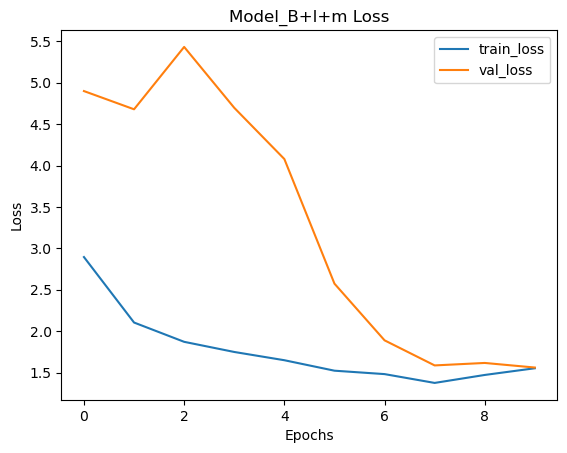

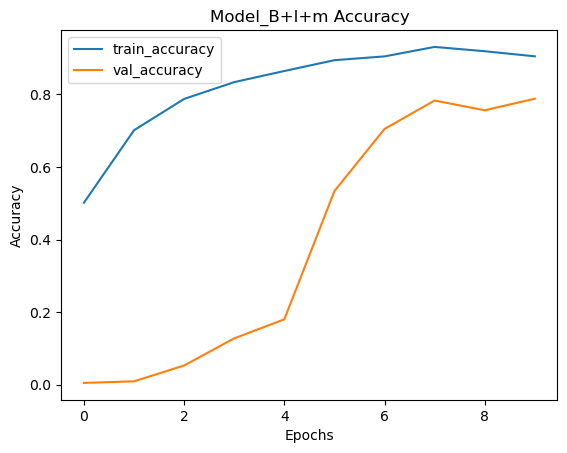

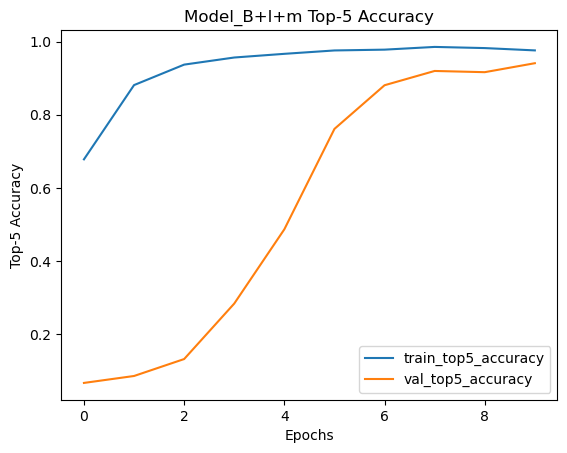

In [12]:
# Visualization Model_B+l+m learning log

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model_B+l+m Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model_B+l+m Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top5_accuracy')
plt.title('Model_B+l+m Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

In [13]:
# Cosine Decay + Label Smoothing + Mixup Train (Model_B+c+l+m)

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

train_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\train'
val_data_dir = 'C:\\Users\\dssal\\OneDrive\\바탕 화면\\이원병\\val'

img_width, img_height = 224, 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lambda_ = np.random.beta(alpha, alpha)
    else:
        lambda_ = 1
    
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    
    mixed_x = lambda_ * x + (1 - lambda_) * x[index]
    mixed_y = lambda_ * y + (1 - lambda_) * y[index]
    
    return mixed_x, mixed_y

def mixup_generator(generator, alpha=0.2):
    while True:
        data = next(generator)
        images, labels = data[0], data[1]
        images, labels = mixup_data(images, labels, alpha)
        yield images, labels

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    if 'conv1' in layer.name:  
        layer.strides = (2, 2)  
    elif 'conv2_block1_0_conv' in layer.name:  
        layer.strides = (1, 1)  

loss = CategoricalCrossentropy(label_smoothing=0.1)

lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=total_epochs*train_generator.samples//batch_size)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'top_k_categorical_accuracy'])

mixup_train_generator = mixup_generator(train_generator)

history = model.fit(
    mixup_train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

val_loss, top1_val_accuracy, top5_val_accuracy = model.evaluate(val_generator)

print("Top-1 Validation Accuracy:", top1_val_accuracy)
print("Top-5 Validation Accuracy:", top5_val_accuracy)

print(history.history)

Found 7316 images belonging to 102 classes.
Found 1828 images belonging to 102 classes.
Epoch 1/10
114/114 [==============================] - 268s 2s/step - loss: 2.9171 - accuracy: 0.4948 - top_k_categorical_accuracy: 0.6693 - val_loss: 5.4312 - val_accuracy: 0.0463 - val_top_k_categorical_accuracy: 0.2059
Epoch 2/10
114/114 [==============================] - 259s 2s/step - loss: 2.1636 - accuracy: 0.6784 - top_k_categorical_accuracy: 0.8748 - val_loss: 5.3600 - val_accuracy: 0.0552 - val_top_k_categorical_accuracy: 0.1044
Epoch 3/10
114/114 [==============================] - 259s 2s/step - loss: 1.7883 - accuracy: 0.7882 - top_k_categorical_accuracy: 0.9335 - val_loss: 5.8255 - val_accuracy: 0.0552 - val_top_k_categorical_accuracy: 0.0915
Epoch 4/10
114/114 [==============================] - 259s 2s/step - loss: 1.6762 - accuracy: 0.8577 - top_k_categorical_accuracy: 0.9647 - val_loss: 5.0304 - val_accuracy: 0.0826 - val_top_k_categorical_accuracy: 0.2042
Epoch 5/10
114/114 [========

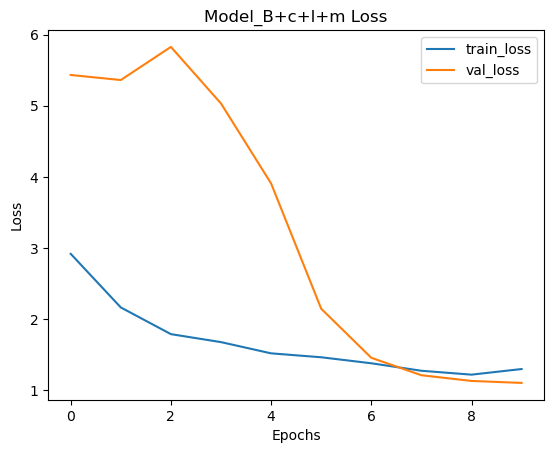

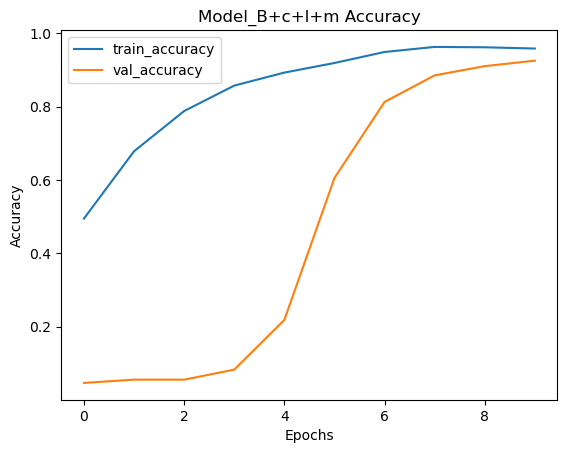

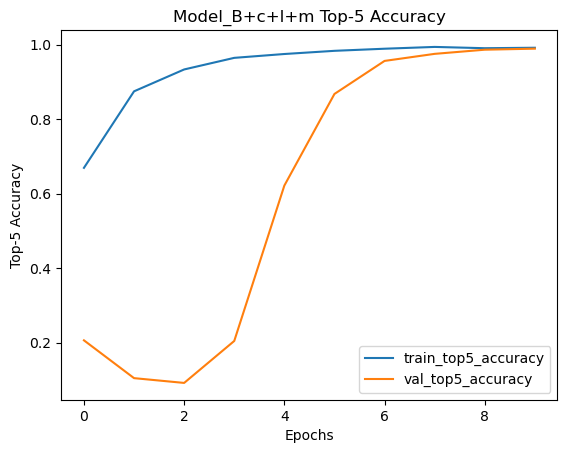

In [14]:
# Visualization Model_B+c+l+m learning log

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model_B+c+l+m Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model_B+c+l+m Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top5_accuracy')
plt.title('Model_B+c+l+m Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()